In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

if os.getcwd().split(os.sep)[-1] == "examples":
    os.chdir('..')

# We import the model, stimuli, and the optimal control package
from neurolib.models.hopf import HopfModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.optimal_control import oc_hopf
from neurolib.optimal_control import cost_functions as cost_functions

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2 

# We define colors for later convenience
color_x = 'red'
color_y = 'blue'

In [2]:
# define plot function for later convenience
def plot_singlenode(model, duration, dt, state, target, control, input, weight_array=[], M=1):
    fig, ax = plt.subplots( 3,1, figsize=(8,6), constrained_layout=True)

    # Plot the target (dashed line) and unperturbed activity
    t_array = np.arange(0, duration+dt, dt)

    ax[0].plot(t_array, state[0,0,:], label="x", color=color_x, linewidth=1)
    ax[0].plot(t_array, state[0,1,:], label="y", color=color_y, linewidth=1)
    ax[0].plot(t_array, target[0,0,:], linestyle='dashed', label="Target x", color=color_x)
    ax[0].plot(t_array, target[0,1,:], linestyle='dashed', label="Target y", color=color_y)
    ax[0].legend()
    ax[0].set_title("Activity without stimulation and target activity")

    for m in range(M-1):
        model.run()
        state = np.concatenate((np.concatenate( (model.params["xs_init"], model.params["ys_init"]), axis=1)[:,:, np.newaxis], np.stack( (model.x, model.y), axis=1)), axis=2)
        ax[0].plot(t_array, state[0,0,:], label="x", color=color_x, linewidth=1)
        ax[0].plot(t_array, state[0,1,:], label="y", color=color_y, linewidth=1)

    # Plot the target control signal (dashed line) and "initial" zero control signal
    ax[1].plot(t_array, control[0,0,:], label="stimulation x", color=color_x)
    ax[1].plot(t_array, control[0,1,:], label="stimulation y", color=color_y)
    ax[1].plot(t_array, input[0,0,:], linestyle='dashed', label="input x", color=color_x)
    ax[1].plot(t_array, input[0,1,:], linestyle='dashed', label="input y", color=color_y)
    ax[1].legend()
    ax[1].set_title("Active stimulation and input stimulation")

    ax[2].plot(weight_array)
    ax[2].set_title("Cost throughout optimization.")

    plt.show()

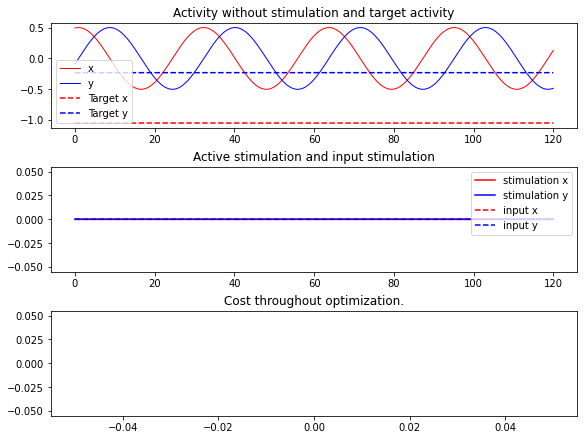

In [3]:
hopf = HopfModel()
hopf.params.sigma_ou = 0.
hopf.params.x_ou_mean = -1.

dt = hopf.params["dt"]
duration = 120.
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
zero_control =np.vstack( [zero_input, zero_input] )[np.newaxis,:,:]

hopf.params["duration"] = duration
x_init = 0.
y_init = 0.
hopf.params["xs_init"] = np.array([[x_init]])
hopf.params["ys_init"] = np.array([[y_init]])
hopf.params["x_ext"] = zero_input
hopf.params["y_ext"] = zero_input
hopf.run()

x_init_down = np.array([[hopf.x[0,-1]]])
y_init_down = np.array([[hopf.y[0,-1]]])
hopf.params["xs_init"] = x_init_down
hopf.params["ys_init"] = y_init_down
hopf.run()

target = np.concatenate((np.concatenate( (hopf.params["xs_init"], hopf.params["ys_init"]), axis=1)[:,:, np.newaxis], np.stack( (hopf.x, hopf.y), axis=1)), axis=2)

hopf.params.x_ou_mean = 0.
hopf.params["xs_init"] = np.array([[0.1]])
hopf.params["ys_init"] = np.array([[y_init]])
hopf.run()

x_init_osc = np.array([[hopf.x[0,-1]]])
y_init_osc = np.array([[hopf.y[0,-1]]])
hopf.params["xs_init"] = x_init_osc
hopf.params["ys_init"] = y_init_osc
hopf.run()

state = np.concatenate((np.concatenate( (hopf.params["xs_init"], hopf.params["ys_init"]), axis=1)[:,:, np.newaxis], np.stack( (hopf.x, hopf.y), axis=1)), axis=2)

plot_singlenode(hopf, duration, dt, state, target, zero_control, zero_control)

Compute control for a deterministic system
Cost in iteration 0: 96.3786187234801


ERROR:root:nan in model output!


diverging model output, decrease step size to  5.0
Cost in iteration 1: 95.0954813577779
Cost in iteration 2: 66.6443081689261
Cost in iteration 3: 42.438461987128996
Cost in iteration 4: 39.92037372067405
Cost in iteration 5: 14.873739695844606
Cost in iteration 6: 11.256428451038085
Cost in iteration 7: 7.052554236059782
Cost in iteration 8: 5.197379111646043
Cost in iteration 9: 3.884930683423826
Cost in iteration 10: 3.0649638375902426
Cost in iteration 11: 2.686547712972878
Cost in iteration 12: 2.040666454094704
Cost in iteration 13: 1.7950567681352878
Cost in iteration 14: 1.4868139712079926
Cost in iteration 15: 1.3985816472847454
Cost in iteration 16: 1.3543427418469043
Cost in iteration 17: 1.2985209733183767
Cost in iteration 18: 1.2684904147299756
Cost in iteration 19: 1.2469414932076734
Cost in iteration 20: 1.2233836569100718
Cost in iteration 21: 1.2084274507327333
Cost in iteration 22: 1.1979530841368555
Cost in iteration 23: 1.1832308649048382
Cost in iteration 24: 1.1

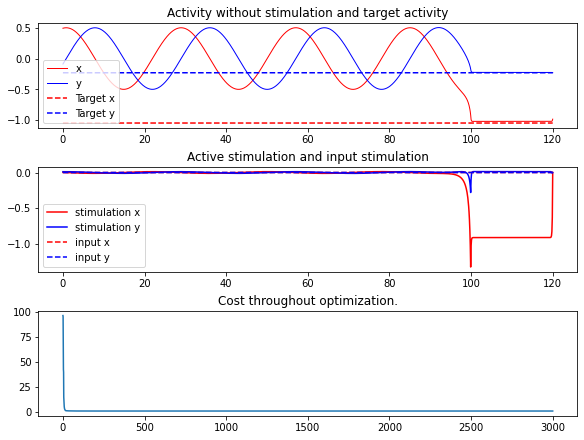

In [5]:
hopf.params["x_ext"] = zero_input
hopf.params["y_ext"] = zero_input
w2 = 1e-2
wp = 1.
printarray = np.concatenate( (np.arange(0,101,1), np.arange(200,1001,100), np.arange(2000,10001,1000)) )
hopf_controlled_noisefree = oc_hopf.OcHopf(hopf, target, w_p=wp, w_2=w2, print_array=printarray, precision_cost_interval=(1000,None))

# We run 100 iterations of the optimal control gradient descent algorithm
hopf_controlled_noisefree.optimize(3000)

state = hopf_controlled_noisefree.get_xs()
control_noisefree = hopf_controlled_noisefree.control

plot_singlenode(hopf_controlled_noisefree.model, duration, dt, state, target, control_noisefree, zero_control, hopf_controlled_noisefree.cost_history)


Compute control for a deterministic system
Cost in iteration 0: 0.9430681783398738
Cost in iteration 1: 0.9430681780337896
Cost in iteration 2: 0.9430681744739393
Cost in iteration 3: 0.9430681730396346
Cost in iteration 4: 0.9430681727171233
Cost in iteration 5: 0.9430681691891629
Cost in iteration 6: 0.9430681677653566
Cost in iteration 7: 0.9430681674305365
Cost in iteration 8: 0.9430681639325347
Cost in iteration 9: 0.9430681625167848
Cost in iteration 10: 0.9430681621791632
Cost in iteration 11: 0.9430681587015642
Cost in iteration 12: 0.9430681572938961
Cost in iteration 13: 0.9430681569573142
Cost in iteration 14: 0.9430681534983938
Cost in iteration 15: 0.94306815209646
Cost in iteration 16: 0.9430681517701028
Cost in iteration 17: 0.9430681483206076
Cost in iteration 18: 0.9430681469244466
Cost in iteration 19: 0.9430681466120158
Cost in iteration 20: 0.9430681431703354
Cost in iteration 21: 0.9430681417776265
Cost in iteration 22: 0.9430681414881983
Cost in iteration 23: 0.94

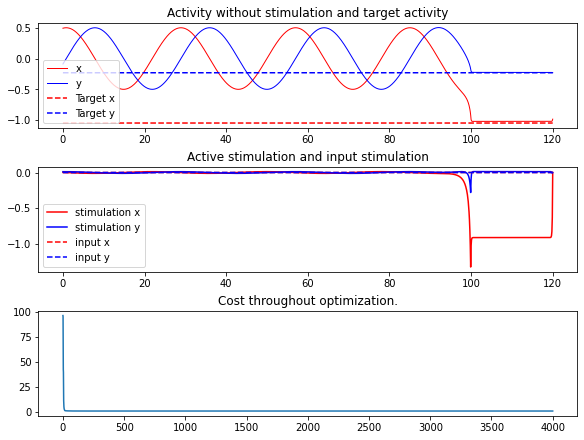

In [6]:
hopf_controlled_noisefree.optimize(1000)

state = hopf_controlled_noisefree.get_xs()
control_noisefree = hopf_controlled_noisefree.control

plot_singlenode(hopf_controlled_noisefree.model, duration, dt, state, target, control_noisefree, zero_control, hopf_controlled_noisefree.cost_history)

In [7]:
sigma_array = [2. * 1e-3, 1. * 1e-2]
M_array = [4,20,100]

weights = np.zeros(( len(sigma_array) ))
controls = [ [None, None, None], [None, None, None]]
costs_history = controls.copy()
costs = np.zeros(( len(sigma_array), len(M_array)+1 ))

In [8]:
hopf_noise = HopfModel()
hopf_noise.params.sigma_ou = 0.
hopf_noise.params.x_ou_mean = 0.

In [9]:
hopf_noise.params.duration = 1. * 1e6
hopf_noise.params["xs_init"] = np.array([[x_init_down]])
hopf_noise.params["ys_init"] = np.array([[y_init_down]])
hopf_noise.params["x_ext"] = zero_input
hopf_noise.params["y_ext"] = zero_input

for i_s in range(len(sigma_array)):
    hopf_noise.params.sigma_ou = sigma_array[i_s]

    hopf_noise.run()
    weights[i_s] = 1. / (np.std(hopf_noise.x[0,100:]) + np.std(hopf_noise.y[0,100:]) )

print(weights)

# [45.99594752  9.07230569]

[1.40847742 1.40541825]


In [16]:
#controls = [ [None, None, None], [None, None, None]]

print(controls[0][0].shape) #, controls[0][1].shape, controls[0][2].shape)
# print(controls[1][0].shape, controls[1][1].shape, controls[1][2].shape)


(1, 2, 1201)


In [21]:
hopf_noise.params.duration = duration
hopf_noise.params["xs_init"] = x_init_osc
hopf_noise.params["ys_init"] = y_init_osc

hopf_noise.params.x_ou_mean = 0.
M_val = 500
max_iterations = 200
hopf_noise.run()
printarray = np.concatenate( (np.arange(0,100,10), np.arange(0,1001,100)) )

# costs_history = [ [None, None, None], [None, None, None]]

for i_s in range(len(sigma_array)):
    for i_m in range(len(M_array)):

        if i_m in []:
            continue

        if i_s in []:
            continue

        costs_history[i_s][i_m] = None

        if type(costs_history[i_s][i_m]) != type(None):
            continue

        print("--------------------------------------------------------------")
        print("---------------------------- sigma, M = ", sigma_array[i_s], M_array[i_m])

        hopf_noise.params["x_ext"] = zero_input
        hopf_noise.params["y_ext"] = zero_input
        hopf_noise.params.sigma_ou = sigma_array[i_s]

        hopf_controlled_models = oc_hopf.OcHopf(hopf_noise, target, w_p=wp, w_2=w2, print_array=printarray, precision_cost_interval=(1000,None),
                                    M=int(M_array[i_m]),
                                    #M = 10,
                                    M_validation=M_val, validate_per_step=True)

        # We run 100 iterations of the optimal control gradient descent algorithm
        hopf_controlled_models.optimize(max_iterations)

        state = hopf_controlled_models.get_xs()
        print(hopf_controlled_models.control.shape)
        controls[i_s][i_m] = hopf_controlled_models.control.copy()
        print(controls[i_s][i_m].shape)
        print(i_s, i_m)
        print(controls[0][0][:,:,:2])
        costs_history[i_s][i_m] = hopf_controlled_models.cost_history
        costs[i_s][i_m+1] = hopf_controlled_models.cost_validation

        # plot_singlenode(hopf_controlled_models.model, duration, dt, state, target, controls[i_s][i_m], zero_control, hopf_controlled_models.cost_history, M=10)

ERROR:root:nan in model output!


--------------------------------------------------------------
---------------------------- sigma, M =  0.002 4
Compute control for a noisy system
Mean cost in iteration 0: 97.03824208114607
diverging model output, decrease step size to  2.5
Mean cost in iteration 10: 4.253561338700029
Mean cost in iteration 20: 1.647501571499977
Mean cost in iteration 30: 1.391840922375492
Mean cost in iteration 40: 1.2532814829756198
Mean cost in iteration 50: 1.1656470777513923
Mean cost in iteration 60: 1.1072836795107743
Mean cost in iteration 70: 1.0534753158870356
Mean cost in iteration 80: 1.0251909605844773
Mean cost in iteration 90: 0.9990395518750584
Mean cost in iteration 100: 0.9860556991527307
Mean cost in iteration 200: 0.9489256098788879
Minimal cost found at iteration 194
Final cost validated with 500 noise realizations : 0.9492795481852535
(1, 2, 1201)
(1, 2, 1201)
0 0
[[[0.00481842 0.00434159]
  [0.02466009 0.02474889]]]
--------------------------------------------------------------


ERROR:root:nan in model output!


Mean cost in iteration 0: 96.92206314157912
diverging model output, decrease step size to  2.5
Mean cost in iteration 10: 4.797146688024165
Mean cost in iteration 20: 2.1038864822362706
Mean cost in iteration 30: 1.7342344366599238
Mean cost in iteration 40: 1.511517593333555
Mean cost in iteration 50: 1.351940754334126
Mean cost in iteration 60: 1.24466504081507
Mean cost in iteration 70: 1.1608146358090827
Mean cost in iteration 80: 1.1044078065638836
Mean cost in iteration 90: 1.0602567516781916
Mean cost in iteration 100: 1.030362726273975
Mean cost in iteration 200: 0.9529556209145228
Minimal cost found at iteration 198
Final cost validated with 500 noise realizations : 0.9532979666363898
(1, 2, 1201)
(1, 2, 1201)
0 1
[[[0.00481842 0.00434159]
  [0.02466009 0.02474889]]]
--------------------------------------------------------------
---------------------------- sigma, M =  0.002 100
Compute control for a noisy system


ERROR:root:nan in model output!


Mean cost in iteration 0: 96.94810323045563
diverging model output, decrease step size to  2.5
Mean cost in iteration 10: 2.352392340064348
Mean cost in iteration 20: 1.2497404404928802
Mean cost in iteration 30: 1.1391973022483883
Mean cost in iteration 40: 1.0826711824054478
Mean cost in iteration 50: 1.0439226611923382
Mean cost in iteration 60: 1.0134658290632144
Mean cost in iteration 70: 0.9934116955876405
Mean cost in iteration 80: 0.9800316473373756
Mean cost in iteration 90: 0.969703944640697
Mean cost in iteration 100: 0.9635566172677795
Mean cost in iteration 200: 0.9468549100838567
Minimal cost found at iteration 199
Final cost validated with 500 noise realizations : 0.946890773060489
(1, 2, 1201)
(1, 2, 1201)
0 2
[[[0.00481842 0.00434159]
  [0.02466009 0.02474889]]]
--------------------------------------------------------------
---------------------------- sigma, M =  0.01 4
Compute control for a noisy system


ERROR:root:nan in model output!
ERROR:root:nan in model output!


Mean cost in iteration 0: 110.68588166420884
diverging model output, decrease step size to  2.5
diverging model output, decrease step size to  0.625
Mean cost in iteration 10: 15.298496711536263
Mean cost in iteration 20: 13.477128245918186
Mean cost in iteration 30: 11.977602901619235
Mean cost in iteration 40: 10.674417466924885
Mean cost in iteration 50: 9.530986485585442
Mean cost in iteration 60: 8.518472079265926
Mean cost in iteration 70: 7.63308535557288
Mean cost in iteration 80: 6.862734694034565
Mean cost in iteration 90: 6.15817663615597
Mean cost in iteration 100: 5.552838575468804
Mean cost in iteration 200: 2.431881125407913
Minimal cost found at iteration 200
Final cost validated with 500 noise realizations : 2.431399522333737
(1, 2, 1201)
(1, 2, 1201)
1 0
[[[0.00481842 0.00434159]
  [0.02466009 0.02474889]]]
--------------------------------------------------------------
---------------------------- sigma, M =  0.01 20
Compute control for a noisy system


ERROR:root:nan in model output!


Mean cost in iteration 0: 110.2902625565638
diverging model output, decrease step size to  2.5
Mean cost in iteration 10: 8.994629162439853
Mean cost in iteration 20: 5.812718129250463
Mean cost in iteration 30: 4.400079073058111
Mean cost in iteration 40: 3.4034580466627014
Mean cost in iteration 50: 2.6952120383143297
Mean cost in iteration 60: 2.214152808808448
Mean cost in iteration 70: 1.8736976374082246
Mean cost in iteration 80: 1.649859614369635
Mean cost in iteration 90: 1.4764314702288137
Mean cost in iteration 100: 1.3269129595439955
Mean cost in iteration 200: 1.0112878034833805
Minimal cost found at iteration 198
Final cost validated with 500 noise realizations : 1.0148748188151555
(1, 2, 1201)
(1, 2, 1201)
1 1
[[[0.00481842 0.00434159]
  [0.02466009 0.02474889]]]
--------------------------------------------------------------
---------------------------- sigma, M =  0.01 100
Compute control for a noisy system


ERROR:root:nan in model output!


Mean cost in iteration 0: 111.53497923948291
diverging model output, decrease step size to  2.5
Mean cost in iteration 10: 9.499787283617417
Mean cost in iteration 20: 6.276888586129681
Mean cost in iteration 30: 4.817294180921706
Mean cost in iteration 40: 3.6693798273640863
Mean cost in iteration 50: 2.9515258656083008
Mean cost in iteration 60: 2.389076671052064
Mean cost in iteration 70: 1.998433263264911
Mean cost in iteration 80: 1.7224241589974625
Mean cost in iteration 90: 1.5120006557599954
Mean cost in iteration 100: 1.372860914843805
Mean cost in iteration 200: 1.0075044395230284
Minimal cost found at iteration 199
Final cost validated with 500 noise realizations : 1.0089653892905748
(1, 2, 1201)
(1, 2, 1201)
1 2
[[[0.00481842 0.00434159]
  [0.02466009 0.02474889]]]


In [18]:
hopf_plot = HopfModel()
hopf_plot.params.x_ou_mean = 0.

hopf_plot.params["duration"] = duration
hopf_plot.params["xs_init"] = x_init_osc
hopf_plot.params["ys_init"] = y_init_osc


In [24]:
for i_s in range(len(sigma_array)):

    print(i_s)

    hopf_plot.params.sigma_ou = sigma_array[i_s]

    hopf_plot.params["x_ext"] = control_noisefree[:,0,:]
    hopf_plot.params["y_ext"] = control_noisefree[:,1,:]

    cost_validation = 0.0
    energy_cost = cost_functions.energy_cost(control_noisefree, w_2=w2)

    for m in range(M_val):
        hopf_plot.run()
        state = np.concatenate((np.concatenate( (hopf_plot.params["xs_init"], hopf_plot.params["ys_init"]), axis=1)[:,:, np.newaxis], np.stack( (hopf_plot.x, hopf_plot.y), axis=1)), axis=2)
        precision_cost = cost_functions.precision_cost(target, state, wp, 1, np.ones( (1, 2)), (1000,None))
        cost_validation += precision_cost + energy_cost

    costs[i_s][0] = cost_validation/M_val

print(costs[0][0], costs[1][0])

0
0.8625894017875725
1
0.8625894017875725
713.5188497689841 717.048819022214


0 0 (1, 2, 1201)
1 0 (1, 2, 1201)
2 0 (1, 2, 1201)
0 1 (1, 2, 1201)
1 1 (1, 2, 1201)
2 1 (1, 2, 1201)


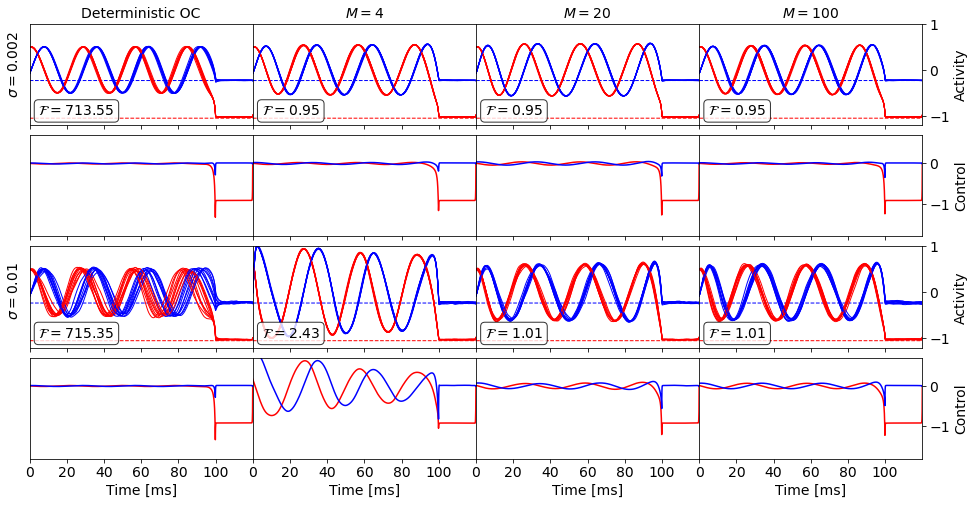

In [22]:
row, col = int(2*len(sigma_array)), int(len(M_array)+1)

fig = plt.figure(figsize=(4*col,2*row))
gs = fig.add_gridspec(row, col, hspace=0.1, wspace=0)
ax = gs.subplots(sharex='col')
box_props = dict(boxstyle='round', facecolor='white', alpha=0.8)
fs = 14
savepath = '..' + os.sep + '..' + os.sep + '..' + os.sep + 'Talks_Conf_Workshops_Schools' + os.sep + '22' + os.sep + '2022_Wittenberg' + os.sep + 'talk' + os.sep + 'talk' + os.sep + 'images'

time_array = np.arange(0, duration+dt, dt)

for i_s in range(len(sigma_array)):
    ax[2*i_s, 0].text(-0.1, 0.3, r'$\sigma = $'+ "{}".format(sigma_array[i_s]),
    transform=ax[2*i_s, 0].transAxes, rotation='vertical', fontsize=fs)

    ax[2*i_s + 1, 0].plot(time_array, control_noisefree[0,0,:], color=color_x)
    ax[2*i_s + 1, 0].plot(time_array, control_noisefree[0,1,:], color=color_y)
    
    hopf_plot.params.sigma_ou = sigma_array[i_s]

    hopf_plot.params["x_ext"] = control_noisefree[:,0,:]
    hopf_plot.params["y_ext"] = control_noisefree[:,1,:]

    ax[2*i_s, 0].plot(time_array[1:], target[0,0,1:], color=color_x, linewidth=1, linestyle='--')
    ax[2*i_s, 0].plot(time_array[1:], target[0,1,1:], color=color_y, linewidth=1, linestyle='--')

    for m in range(10):
        hopf_plot.run()
        ax[2*i_s, 0].plot(time_array[1:], hopf_plot.x[0,:], color=color_x, linewidth=1)
        ax[2*i_s, 0].plot(time_array[1:], hopf_plot.y[0,:], color=color_y, linewidth=1)

    ax[2*i_s, 0].text(0.04,0.1, r'$\mathcal{F} = $' + "{:.2f}".format(costs[i_s][0]),
        transform=ax[2*i_s, 0].transAxes, fontsize=fs, bbox=box_props)

    for i_m in range(len(M_array)):
        print(i_m, i_s, controls[i_s][i_m].shape)
        ax[2*i_s + 1, i_m+1].plot(time_array, controls[i_s][i_m][0,0,:], color=color_x)
        ax[2*i_s + 1, i_m+1].plot(time_array, controls[i_s][i_m][0,1,:], color=color_y)

        ax[2*i_s, i_m+1].text(0.04,0.1, r'$\mathcal{F} = $' + "{:.2f}".format(costs[i_s][i_m+1]),
        transform=ax[2*i_s, i_m+1].transAxes, fontsize=fs, bbox=box_props)

        hopf_plot.params["x_ext"] = controls[i_s][i_m][:,0,:]
        hopf_plot.params["y_ext"] = controls[i_s][i_m][:,1,:]

        ax[2*i_s, i_m+1].plot(time_array[1:], target[0,0,1:], color=color_x, linewidth=1, linestyle='--')
        ax[2*i_s, i_m+1].plot(time_array[1:], target[0,1,1:], color=color_y, linewidth=1, linestyle='--')

        for m in range(10):
            hopf_plot.run()
            ax[2*i_s, i_m+1].plot(time_array[1:], hopf_plot.x[0,:], color=color_x, linewidth=1)
            ax[2*i_s, i_m+1].plot(time_array[1:], hopf_plot.y[0,:], color=color_y, linewidth=1)



    for k in range(col-1):
        ax[2*i_s,k].set_yticks([])
        ax[2*i_s+1,k].set_yticks([])

    for k in range(col):
        ax[2*i_s,k].set_ylim([-1.2, 1.])
        ax[2*i_s+1,k].set_ylim([-1.8, 0.7])
    
    ax[2*i_s,-1].yaxis.tick_right()
    ax[2*i_s+1,-1].yaxis.tick_right()

    ax[2*i_s,-1].set_ylabel("Activity", fontsize=fs)
    ax[2*i_s,-1].yaxis.set_label_position("right")
    ax[2*i_s+1,-1].set_ylabel("Control", fontsize=fs)
    ax[2*i_s+1,-1].yaxis.set_label_position("right")


for k in range(col):
    for j in range(row-1):
        ax[j,k].set_xticks([])
        ax[j,k].set_xlim([0,duration])
        ax[j,k].tick_params(axis='both', labelsize=fs)
    ax[-1,k].set_xticks(np.arange(0,120,20))
    ax[-1,k].set_xlim([0,duration])
    ax[-1,k].tick_params(axis='both', labelsize=fs)
    ax[-1,k].set_xlabel("Time [ms]", fontsize=fs)

for i_m in range(len(M_array)):
    ax[0,i_m+1].set_title(r"$M=$" + "{}".format(M_array[i_m]), fontsize=fs)

ax[0,0].set_title(r"Deterministic OC", fontsize=fs)

fig.savefig(os.path.join(savepath, 'Hopf_osc_down_traces.jpg'), bbox_inches='tight')
plt.show()


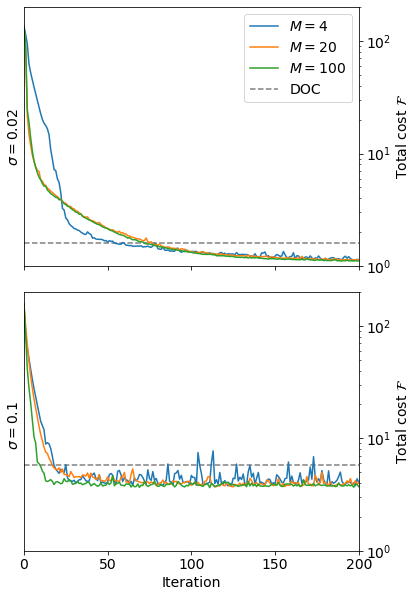

In [ ]:
row, col = len(sigma_array), 1

fig = plt.figure(figsize=(6,5*row))
gs = fig.add_gridspec(row, col, hspace=0.1, wspace=0)
ax = gs.subplots(sharex='col')

for i_s in range(len(sigma_array)):
    for i_m in range(len(M_array)):
        ax[i_s].plot(costs_history[i_s][i_m], label=r'$M=$' + '{}'.format(M_array[i_m]))

    ax[i_s].hlines(costs[i_s,0], 0, max_iterations, label='DOC', linestyle='--', color='grey')

    ax[i_s].text(-0.05, 0.4, r'$\sigma = $'+ "{}".format(sigma_array[i_s]), transform=ax[i_s].transAxes, rotation='vertical', fontsize=fs)

    ax[i_s].set_ylabel(r'Total cost $\mathcal{F}$', fontsize=fs)
    ax[i_s].yaxis.set_label_position("right")
    ax[i_s].yaxis.tick_right()
    ax[i_s].tick_params(axis='both', labelsize=fs)
    ax[i_s].set_xlim([0,max_iterations])
    ax[i_s].set_yscale('log')
    ax[i_s].set_ylim(1., 200)

ax[0].legend(loc='upper right', fontsize=fs)
ax[-1].set_xlabel("Iteration", fontsize=fs)


fig.savefig(os.path.join(savepath, 'Hopf_osc_down_cost.jpg'), bbox_inches='tight')
plt.show()